# Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import time
import csv
from PIL import Image

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import (Conv2D, MaxPooling2D, Flatten, 
                          Dense, Dropout, BatchNormalization, 
                          LeakyReLU, DepthwiseConv2D, MaxPooling2D,
                          Add, Input, Activation, GlobalAveragePooling2D,
                          Multiply, Reshape)


from keras.utils import get_file
from keras.models import model_from_json

2023-05-27 23:14:46.775580: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-27 23:14:46.850086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 23:14:51.135709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os 
import logging

# Set Tensorflow log level to error 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Set logger level to ERROR
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)  # Set logger level to ERROR

# Paths

In [3]:
# Training sets
raw_train_path = "../02_Data/face_age_data/face_age_balanced_train"
aug_train_path = "../02_Data/face_age_data/augmented_data_train" 


# Validation set
raw_val_path = "../02_Data/face_age_data/face_age_balanced_val"

# Testing set
raw_test_path = "../02_Data/face_age_data/face_age_balanced_test"

# Load Datasets

In [4]:
def load_data(folders, img_size=(200, 200)):
    X = []
    y = []
    for folder_path in folders:
        for folder in os.listdir(folder_path):
            if os.path.isdir(os.path.join(folder_path, folder)):
                age = int(folder.replace("aug_", ""))
                for file in os.listdir(os.path.join(folder_path, folder)):
                    img_path = os.path.join(folder_path, folder, file)
                    img = Image.open(img_path)
                    img = img.resize(img_size)
                    img = np.array(img)
                    X.append(img)
                    y.append(age)
    return np.array(X), np.array(y)

In [5]:
img_size = (200, 200)

# # Load training set
# folder_paths_train = [
#     raw_train_path, 
#     aug_train_path
#     ]
# X_train, y_train = load_data(folder_paths_train, img_size)
# X_train = X_train / 255.0  # Normalize pixel values

# Load validation set
folder_paths_val = [raw_val_path]
X_val, y_val = load_data(folder_paths_val, img_size)
X_val = X_val / 255.0  # Normalize pixel values

# Load testing set
folder_paths_test = [raw_test_path]
X_test, y_test = load_data(folder_paths_test, img_size)
X_test = X_test / 255.0  # Normalize pixel values


In [6]:
# Load raw training set
X_raw_train, y_raw_train = load_data([raw_train_path], img_size)
X_raw_train = X_raw_train / 255.0  # Normalize pixel values

# Load augmented training set
X_aug_train, y_aug_train = load_data([aug_train_path], img_size)
X_aug_train = X_aug_train / 255.0  # Normalize pixel values

# Concatenate raw and augmented training set
X_train = np.concatenate((X_raw_train, X_aug_train), axis=0)
y_train = np.concatenate((y_raw_train, y_aug_train), axis=0)

# Now check the maximum and minimum pixel values in X_train
print("Max pixel value in X_train after normalization:", np.max(X_train))
print("Min pixel value in X_train after normalization:", np.min(X_train))



Max pixel value in X_train after normalization: 1.0
Min pixel value in X_train after normalization: 0.0


In [7]:
print(
    f"Shape of X: {X_train.shape}", "\n",
    f"- {X_train.shape[0]}: Number of images in the dataset", "\n",
    f"- {X_train.shape[1]}: Height of each image", "\n",
    f"- {X_train.shape[2]}: Width of each image", "\n",
    f"- {X_train.shape[3]}: Number of channels of each image (Red, Green, and Blue)"
    )

Shape of X: (45000, 200, 200, 3) 
 - 45000: Number of images in the dataset 
 - 200: Height of each image 
 - 200: Width of each image 
 - 3: Number of channels of each image (Red, Green, and Blue)


In [8]:
print(f"Labels: {y_train}")

Labels: [32 32 32 ... 58 58 58]


In [9]:
print(
    f"Size of arrays:", "\n",
    f"- X_train shape: {X_train.shape}", "\n",
    f"- y_train shape: {y_train.shape}", "\n",
    f"- X_val shape: {X_val.shape}", "\n",
    f"- y_val shape: {y_val.shape}", "\n",
    f"- X_test shape: {X_test.shape}", "\n",
    f"- y_test shape: {y_test.shape}", "\n",
    )

Size of arrays: 
 - X_train shape: (45000, 200, 200, 3) 
 - y_train shape: (45000,) 
 - X_val shape: (1400, 200, 200, 3) 
 - y_val shape: (1400,) 
 - X_test shape: (1750, 200, 200, 3) 
 - y_test shape: (1750,) 



# Model Setup

#### Check for GPUs

In [10]:
def set_gpus(*gpu_indices):
    # Get list of GPUs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))

    if gpus:
        visible_gpus = [gpus[i] for i in gpu_indices]
        try:
            # Only use specified GPUs and ignore the others
            tf.config.experimental.set_visible_devices(visible_gpus, 'GPU')
            for gpu in visible_gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Using GPUs: ", [gpu.name for gpu in visible_gpus])
        except RuntimeError as e:
            print(e)
    return visible_gpus

# Call the function with the indices of the GPUs you want to use
visible_gpus = set_gpus(0, 1, 2, 3, 4)  # Use the second, third, fourth, and fifth GPU

# Extract names of the GPUs being used
gpu_names = ['/device:GPU:' + gpu.name.split(':')[-1] for gpu in visible_gpus]
print(gpu_names)


Num GPUs Available:  5
Using GPUs:  ['/physical_device:GPU:0', '/physical_device:GPU:1', '/physical_device:GPU:2', '/physical_device:GPU:3', '/physical_device:GPU:4']
['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3', '/device:GPU:4']


#### Set up training

In [11]:
# Training parameters
epochs = 1000
batch_size = 32
optimizer = "adam"
loss = "mean_squared_error"
metrics = ['mae']

In [12]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=gpu_names)

# 13
# 1684407927.h5
# Augmented + Raw data

def Conv_BN(x, filters, kernel_size, strides=1):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

def SE_Block(input, ratio=4):
    num_filters = input.shape[-1]
    x = GlobalAveragePooling2D()(input)
    x = Dense(num_filters//ratio, activation='relu')(x)
    x = Dense(num_filters, activation='sigmoid')(x)
    x = Reshape((1, 1, num_filters))(x)
    out = Multiply()([input, x])
    return out

def MBConv(x, in_channels, out_channels, expansion_factor, stride, k, se_ratio=0.25, id_skip=True):
    x = Conv_BN(x, in_channels*expansion_factor, (1, 1))
    x = Activation('relu')(x)
    x = DepthwiseConv2D(k, strides=(stride, stride), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if se_ratio:
        x = SE_Block(x, ratio=se_ratio)

    x = Conv2D(out_channels, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    
    if id_skip:
        if in_channels == out_channels and stride == 1:
            x = Add()([x, input])
    return x

def create_model(input_shape):
    input = Input(shape=input_shape)
    x = Conv_BN(input, 32, (3, 3), strides=2)
    x = Activation('relu')(x)

    x = MBConv(x, in_channels=32, out_channels=16, expansion_factor=1, stride=1, k=3)
    x = MBConv(x, in_channels=16, out_channels=24, expansion_factor=6, stride=2, k=3)
    x = MBConv(x, in_channels=24, out_channels=40, expansion_factor=6, stride=2, k=5)
    x = MBConv(x, in_channels=40, out_channels=80, expansion_factor=6, stride=2, k=3)
    x = MBConv(x, in_channels=80, out_channels=112, expansion_factor=6, stride=1, k=5)
    x = MBConv(x, in_channels=112, out_channels=192, expansion_factor=6, stride=2, k=5)
    x = MBConv(x, in_channels=192, out_channels=320, expansion_factor=6, stride=1, k=3)

    x = Conv_BN(x, 1280, (1, 1))
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)

    output = Dense(1)(x)  # For regression, single output with no activation function

    model = Model(input, output)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)  # Suitable for regression

    return model

# Open the strategy scope
with strategy.scope():
    input_shape = (img_size[0], img_size[1], 3)
    model = create_model(input_shape)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-05-27 23:20:59.181226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46671 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-05-27 23:20:59.182077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46671 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-05-27 23:20:59.182702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46671 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:88:00.0, compute capability: 8.6
2023-05-27 23:20:59.183330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46671 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:89:00.0, 

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

#### Train model

In [13]:
# Create a callback to save the model's weights
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("../04_Age_Prediction/08_models/best_model.h5", save_best_only=True)

# Create a callback that stops the training if there is no improvement in the validation loss for 15 consecutive epochs
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

In [14]:
# Train the model with your data
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=1,
                    callbacks=[checkpoint_cb, early_stopping_cb])

2023-05-27 19:05:55.330307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [45000]
	 [[{{node Placeholder/_11}}]]
2023-05-27 19:05:55.330660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [45000,200,200,3]
	 [[{{node Placeholder/_10}}]]


Epoch 1/1000
INFO:tensorflow:batch_all_reduce: 113 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 113 all-reduces with algorithm = nccl, num_packs = 1


2023-05-27 19:06:44.427453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-27 19:06:47.131115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-27 19:06:49.898576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-27 19:06:52.229888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-27 19:06:52.286827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-27 19:06:54.060615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-27 19:07:01.462249: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f99ef4bf480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-27 19:07:01.462289: I tens

1407/1407 [==============================] - ETA: 0s - loss: 324.4764 - mae: 13.6736

2023-05-27 19:09:52.281838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [1750]
	 [[{{node Placeholder/_11}}]]
2023-05-27 19:09:52.282167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [1750]
	 [[{{node Placeholder/_11}}]]


1407/1407 [==============================] - 245s 118ms/step - loss: 324.4764 - mae: 13.6736 - val_loss: 116.7091 - val_mae: 8.1648
Epoch 2/1000
1407/1407 [==============================] - 155s 110ms/step - loss: 116.5278 - mae: 8.2043 - val_loss: 106.4826 - val_mae: 7.4454
Epoch 3/1000
1407/1407 [==============================] - 154s 110ms/step - loss: 81.6833 - mae: 6.8134 - val_loss: 90.7731 - val_mae: 6.8835
Epoch 4/1000
1407/1407 [==============================] - 152s 108ms/step - loss: 66.0395 - mae: 6.1261 - val_loss: 93.7535 - val_mae: 6.9483
Epoch 5/1000
1407/1407 [==============================] - 154s 109ms/step - loss: 54.4593 - mae: 5.5212 - val_loss: 80.7043 - val_mae: 6.4781
Epoch 6/1000
1407/1407 [==============================] - 152s 108ms/step - loss: 47.4794 - mae: 5.1687 - val_loss: 97.9953 - val_mae: 7.0528
Epoch 7/1000
1407/1407 [==============================] - 152s 108ms/step - loss: 40.4921 - mae: 4.7798 - val_loss: 87.4484 - val_mae: 6.8393
Epoch 8/1000
1

In [14]:
model = tf.keras.models.load_model('./08_models/best_custom.h5')

2023-05-27 23:25:23.840389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900


 9/44 [=====>........................] - ETA: 0s

2023-05-27 23:25:24.626010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


44/44 [==============================] - 3s 15ms/step


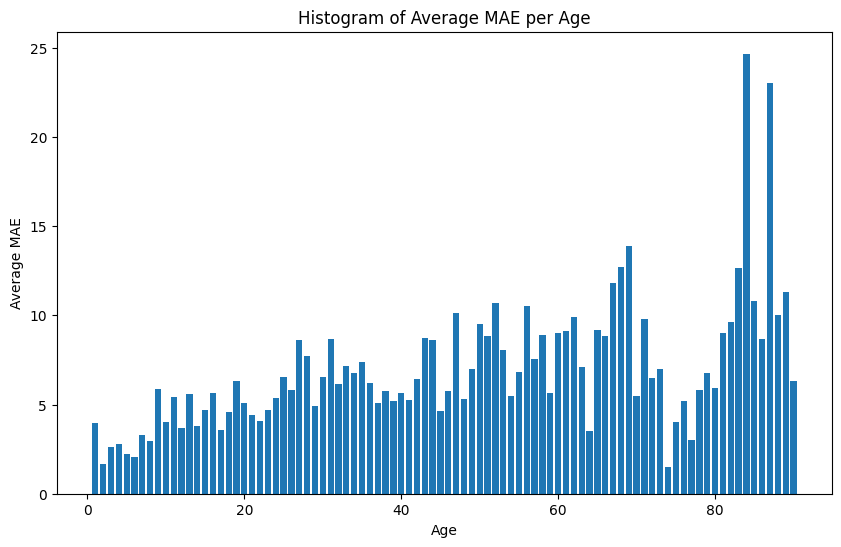

In [15]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Predict on the validation set
y_val_pred = model.predict(X_val)

# convert predictions and actual values to integers because age is a discrete variable
y_val = y_val.astype(int)
y_val_pred = y_val_pred.astype(int)

# Create a DataFrame to store actual and predicted values
df = pd.DataFrame({'Actual': y_val, 'Predicted': y_val_pred.flatten()})

# Calculate the mean absolute error for each age
df['MAE'] = abs(df['Actual'] - df['Predicted'])
mae_per_age = df.groupby('Actual')['MAE'].mean()

# Plot a histogram of average MAE per age
plt.figure(figsize=(20,10))
plt.bar(mae_per_age.index, mae_per_age.values)
plt.xlabel('Age')
plt.ylabel('Average MAE')
plt.title('Histogram of Average MAE per Age')
plt.show()

# Save, Load, and Display Model History

In [16]:
# Model attributes
timestamp = int(time.time())
file_name = '../04_Age_Prediction/model_history.csv'
description = f"{timestamp}"
input_shape = str(X_train.shape[1:])
num_params = model.count_params()
epochs = len(history.history['loss'])
optimizer = optimizer
loss_function = loss
train_mae = min(history.history['mae'])
validation_mae = min(history.history['val_mae'])

In [17]:
def append_model_history_to_file(file_name, description, input_shape, num_params, epochs, batch_size, optimizer, loss_function, train_mae, validation_mae):
    train_mae = round(train_mae, 6)
    validation_mae = round(validation_mae, 6)

    if not os.path.exists(file_name):
        with open(file_name, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Model', 'Input Shape', 'Model Params', 'Epochs', 'Batch Size', 'Optimizer', 'Loss Function', 'Train MAE', 'Validation MAE'])

    with open(file_name, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        try:
            next(csv_reader)  # Skip the header row
        except StopIteration:
            pass  # The CSV file is empty or only contains the header row

        for row in csv_reader:
            if list(map(str, row[1:])) == list(map(str, [input_shape, num_params, epochs, batch_size, optimizer, loss_function, train_mae, validation_mae])):
                print("Entry with the same parameters already exists.")
                return False

    with open(file_name, 'a', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow([description, input_shape, num_params, epochs, batch_size, optimizer, loss_function, train_mae, validation_mae])

    return True

new_entry_added = append_model_history_to_file(file_name, description, input_shape, num_params, epochs, batch_size, optimizer, loss_function, train_mae, validation_mae)

# Save model
def save_model_architecture(model, file_name):
    model_json = model.to_json()
    with open(file_name, "w") as json_file:
        json_file.write(model_json)

if new_entry_added:
    model_file = f"../04_Age_Prediction/08_models/{description}.h5"
    model.save(model_file)
    print(f"Model saved at {model_file}")
else:
    print("Model not saved as an entry with the same parameters already exists.")

Model saved at ../04_Age_Prediction/08_models/1685216891.h5


In [18]:
def load_data_to_dataframe(file_name):
    if not os.path.exists(file_name):
        print("File does not exist.")
        return None
    
    df = pd.read_csv(file_name)
    return df

file_name = '../04_Age_Prediction/model_history.csv'
df = load_data_to_dataframe(file_name)

df

ParserError: Error tokenizing data. C error: Expected 9 fields in line 18, saw 17


In [ ]:
# # Specify model to load
# model_to_load = "1683270923"

# def load_and_display_model_architecture(file_name):
#     if not os.path.exists(file_name):
#         print("File does not exist.")
#         return None

#     with open(file_name, "r") as json_file:
#         model_json = json_file.read()
    
#     model = model_from_json(model_json)
#     model.summary()

#     return model

# model_architecture_file = f"../04_Age_Prediction/models/{model_to_load}.json"
# model = load_and_display_model_architecture(model_architecture_file)

# 